In [1]:
import os 
import numpy as np
import cv2 as cv2
import tensorflow as tf
import os
np.random.seed(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(tf.__version__)


2.17.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


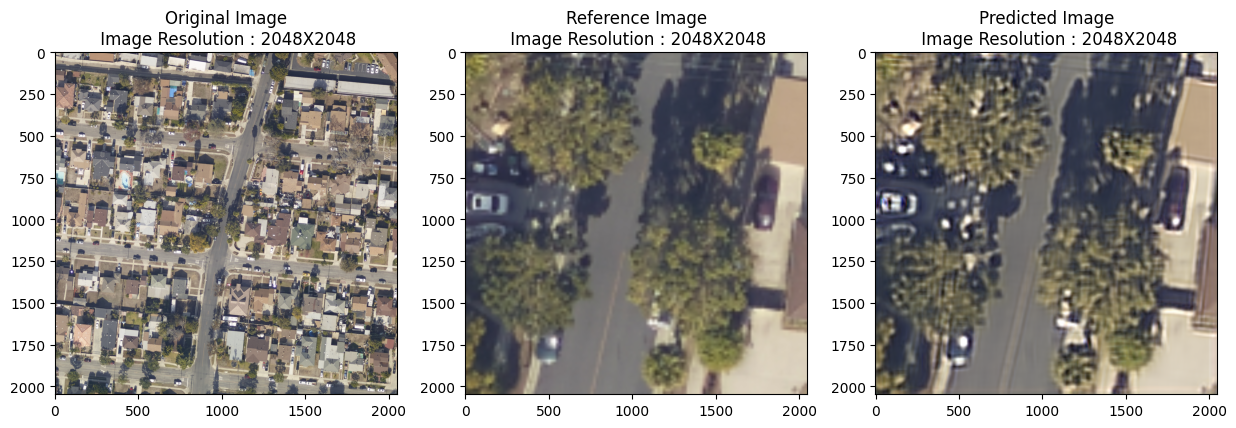

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model

# Skew correction function
def correct_skew(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # Thresholding the image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Find the coordinates of non-zero pixels
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # Adjust angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Rotate the image to correct skew
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    corrected_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return corrected_image

# Tone mapping function
def apply_tone_mapping(image):
    # Convert to HDR
    ldr = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
    tonemap = cv2.createTonemap(gamma=2.2)  # Using gamma correction for tone mapping
    res = tonemap.process(ldr)
    res_8bit = np.clip(res * 255, 0, 255).astype(np.uint8)
    return cv2.cvtColor(res_8bit, cv2.COLOR_RGB2BGR)

loadded_model = load_model('./saved_models/SRCNN_e_20.h5', compile=False)
loadded_model.save("SRCNN_e_" + "20" + ".h5")

def center_crop(image, size):
    height, width = image.shape[:2]
    target_height, target_width = size

    # Calculate crop coordinates
    start_y = max(0, int((height - target_height) / 2))
    end_y = start_y + target_height
    start_x = max(0, int((width - target_width) / 2))
    end_x = start_x + target_width

    # Perform center crop
    cropped_image = image[start_y:end_y, start_x:end_x]

    return cropped_image


# Load and preprocess the original image
image_path = './test_images/test_image.jpg'
image = cv2.imread(image_path)
cropped_image = center_crop(image, (256, 256))
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
cropped_image = cv2.resize(cropped_image, (256, 256))
cropped_image = cropped_image.astype('float32') / 255.0
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255.0

# Make a prediction
prediction = loadded_model.predict(np.expand_dims(cropped_image, axis=0))[0]
prediction = np.clip(prediction, 0, 1)  # Clip values between 0 and 1

cropped_image = cv2.resize(cropped_image, (cropped_image.shape[0]//2, cropped_image.shape[1]//2))
cropped_image = cv2.resize(cropped_image, (image.shape[0], image.shape[1]))
prediction = cv2.resize(prediction, (image.shape[0], image.shape[1]))
# Display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title(f'Original Image\n Image Resolution : {image.shape[0]}X{image.shape[1]}')
axes[1].imshow(cropped_image)
axes[1].set_title(f'Reference Image\n Image Resolution : {cropped_image.shape[0]}X{cropped_image.shape[1]}')
axes[2].imshow(prediction)
axes[2].set_title(f'Predicted Image\n Image Resolution : {prediction.shape[0]}X{prediction.shape[1]}')
plt.show()
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
prediction = cv2.cvtColor(prediction, cv2.COLOR_RGB2BGR)


In [6]:
cv2.imshow('Original Image',image)
cv2.imshow('Reference Image',cropped_image)
cv2.imshow('Predicted Image',prediction)
cv2.waitKey(0)
cv2.destroyAllWindows()